In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler


# 加载数据
df = pd.read_csv("../Data/Q2_german_credit_data_with_scores.csv")

# 假设'Credit_Score'是包含信用得分的列名
scores = df['Credit_Score'].values

# 归一化得分到[0,1]区间
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(scores.reshape(-1, 1)).flatten()

# 定义目标函数：最小化组内方差
def objective(boundaries, scores):
    boundaries = np.sort(boundaries)
    boundaries = np.concatenate(([0], boundaries, [1]))
    groups = np.digitize(scores, boundaries[1:-1])
    return sum(np.var(scores[groups == i]) for i in range(len(boundaries)-1))

# 定义约束条件：边界值必须在[0,1]之间且递增
def constraint(boundaries):
    return np.diff(np.concatenate(([0], boundaries, [1])))

# 使用非线性规划求解最优边界
n_groups = 5
initial_boundaries = np.linspace(0, 1, n_groups+1)[1:-1]
result = minimize(objective, initial_boundaries, args=(normalized_scores,),
                  method='SLSQP', constraints={'type': 'ineq', 'fun': constraint})

# 获取最优边界
optimal_boundaries = np.sort(result.x)
optimal_boundaries = np.concatenate(([0], optimal_boundaries, [1]))

# 根据最优边界划分信用等级
credit_ratings = np.digitize(normalized_scores, optimal_boundaries[1:-1])

# 将信用等级映射到1-5（5表示最高信用）
credit_ratings = n_groups - credit_ratings + 1

# 将信用等级添加回DataFrame
df['Credit_Rating'] = credit_ratings

# 保存结果
df.to_csv('../Data/Q4_german_credit_data_with_ratings_nonlinear.csv', index=False)

# 打印结果
print(df[['Credit_Score', 'Credit_Rating']])

# 打印最优边界
print("\nOptimal boundaries:")
for i, boundary in enumerate(optimal_boundaries[1:-1], 1):
    print(f"Boundary {i}: {scaler.inverse_transform([[boundary]])[0][0]:.2f}")

     Credit_Score  Credit_Rating
0         10966.0              3
1          6329.0              5
2          8731.0              4
3          8215.0              4
4          9797.0              4
..            ...            ...
995        7143.0              5
996        6688.0              5
997        8683.0              4
998        7844.0              4
999        9083.0              4

[1000 rows x 2 columns]

Optimal boundaries:
Boundary 1: 5688.60
Boundary 2: 7819.20
Boundary 3: 9949.80
Boundary 4: 12080.40


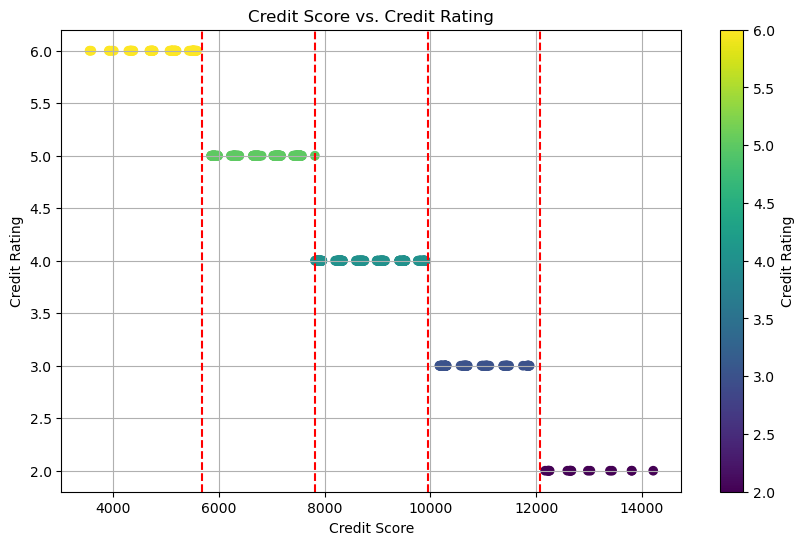

In [2]:
import matplotlib.pyplot as plt

# 可视化聚类结果
plt.figure(figsize=(10, 6))

# 绘制信用评分和信用等级的散点图
plt.scatter(df['Credit_Score'], df['Credit_Rating'], c=credit_ratings, cmap='viridis', marker='o')
plt.colorbar(label='Credit Rating')
plt.xlabel('Credit Score')
plt.ylabel('Credit Rating')
plt.title('Credit Score vs. Credit Rating')
plt.grid(True)

# 添加边界线
for boundary in optimal_boundaries[1:-1]:
    plt.axvline(scaler.inverse_transform([[boundary]])[0][0], color='r', linestyle='--')

plt.savefig('../Data/Q4_Credit_Score_vs_Credit_Rating.png')
plt.show()
